In [1]:
MAX_TIME = 300 # Time in minutes. Counter starts, after the initial design is evaluated. So, runtime can be larger.
INIT_SIZE = 20 # Initial number of designs to evaluate, before the surrogate is build.
ORIGINAL = False # If True, the original data is used.

In [2]:
import socket
import os
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '16-sklearnRandomForestClassifier' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
print(experiment_name)
if not os.path.exists('./figures'):
    os.makedirs('./figures')

16-sklearnRandomForestClassifier_maans05_300min_20init_2023-05-29_23-38-59


# Chapter 16: Sequential Parameter Optimization
## Hyperparameter Tuning: sklearn RandomForestClassifier

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).


In [3]:
pip list | grep  "spot[RiverPython]"

spotPython               0.2.2
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython

In [5]:
from tabulate import tabulate
import warnings
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder , MinMaxScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline , Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_curve, roc_auc_score, log_loss, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import top_k_accuracy_score

warnings.filterwarnings("ignore")

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    convert_keys,
    get_bound_values,
    get_default_hyperparameters_for_core_model,
    get_default_values,
    get_default_hyperparameters_as_array,
    get_dict_with_levels_and_types,
    get_values_from_dict,
    get_var_name,
    get_var_type,
    iterate_dict_values,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    replace_levels_with_positions,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
    transform_hyper_parameter_values,
    get_dict_with_levels_and_types,
    convert_keys,
    iterate_dict_values,
    get_one_sklearn_model_from_X
)

from spotPython.utils.convert import class_for_name
from spotPython.utils.eda import (
    get_stars,
    gen_design_table)
from spotPython.utils.transform import transform_hyper_parameter_values
from spotPython.utils.convert import get_Xy_from_df
from spotPython.plot.validation import plot_cv_predictions, plot_roc, plot_confusion_matrix
from spotPython.utils.init import fun_control_init

from spotPython.data.sklearn_hyper_dict import SklearnHyperDict
from spotPython.fun.hypersklearn import HyperSklearn
from spotPython.utils.metrics import mapk_score

## 0. Initialization of the Empty `fun_control` Dictionary

In [6]:
fun_control = fun_control_init()

## 1. Load Data: Classification

## Vector Borne Disease Prediction Data

In [7]:
if ORIGINAL == True:
    train_df = pd.read_csv('./data/VBDP/trainn.csv')
    test_df = pd.read_csv('./data/VBDP/testt.csv')
else:
    train_df = pd.read_csv('./data/VBDP/train.csv')
    # remove the id column
    train_df = train_df.drop(columns=['id'])

In [8]:
n_samples = train_df.shape[0]
n_features = train_df.shape[1] - 1
target_column = "prognosis"
# Encoder our prognosis labels as integers for easier decoding later
enc = OrdinalEncoder()
train_df[target_column] = enc.fit_transform(train_df[[target_column]])
train_df.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
print(train_df.shape)
train_df.head()

(707, 65)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x56,x57,x58,x59,x60,x61,x62,x63,x64,prognosis
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,6.0


The full data set `train_df` 64 features. The target column is labeled as `prognosis`.

## Holdout Train and Test Data

We split out a hold-out test set (25% of the data) so we can calculate an example MAP@K

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target_column, axis=1), train_df[target_column],
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=train_df[target_column])
train = pd.DataFrame(np.hstack((X_train, np.array(y_train).reshape(-1, 1))))
test = pd.DataFrame(np.hstack((X_test, np.array(y_test).reshape(-1, 1))))
train.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
test.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
print(train.shape)
print(test.shape)
train.head()

(530, 65)
(177, 65)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x56,x57,x58,x59,x60,x61,x62,x63,x64,prognosis
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
3,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [10]:
# add the dataset to the fun_control
fun_control.update({"data": train_df, # full dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": target_column})

## 2. Specification of the Preprocessing Model

Data preprocesssing can be very simple, e.g., you can ignore it. Then you would choose the `prep_model` "None":

In [11]:
prep_model = None
fun_control.update({"prep_model": prep_model})

A default approach for numerical data is the `StandardScaler` (mean 0, variance 1).  This can be selected as follows:

In [12]:
# prep_model = StandardScaler()
# fun_control.update({"prep_model": prep_model})

Even more complicated pre-processing steps are possible, e.g., the follwing pipeline:

In [13]:
# categorical_columns = []
# one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# prep_model = ColumnTransformer(
#         transformers=[
#             ("categorical", one_hot_encoder, categorical_columns),
#         ],
#         remainder=StandardScaler(),
#     )

## 3. Select `algorithm` and `core_model_hyper_dict`

The selection of the algorithm (ML model) that should be tuned is done by specifying the its name from the `sklearn` implementation.  For example, the `SVC` support vector machine classifier is selected as follows:

`fun_control = add_core_model_to_fun_control(SVC, fun_control, SklearnHyperDict)`


Other core_models are, e.g.,:

* RidgeCV
* GradientBoostingRegressor
* ElasticNet
* RandomForestClassifier
* LogisticRegression
* KNeighborsClassifier
* RandomForestClassifier
* GradientBoostingClassifier
* HistGradientBoostingClassifier

We will use the `RandomForestClassifier` classifier in this example.

In [14]:
fun_control = add_core_model_to_fun_control(core_model=RandomForestClassifier,
                              fun_control=fun_control,
                              hyper_dict=SklearnHyperDict,
                              filename=None)

Now `fun_control` has the information from the JSON file. The available hyperparameters are:

In [15]:
print(*fun_control["core_model_hyper_dict"].keys(), sep="\n")

n_estimators
criterion
max_depth
min_samples_split
min_samples_leaf
min_weight_fraction_leaf
max_features
max_leaf_nodes
min_impurity_decrease
bootstrap
oob_score


## 4. Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

### Modify hyperparameter of type factor

Factors can be modified with the `modify_hyper_parameter_levels` function.  For example, to exclude the `sigmoid` kernel from the tuning, the `kernel` hyperparameter of the `SVC` model can be modified as follows:

`fun_control = modify_hyper_parameter_levels(fun_control, "kernel", ["linear", "rbf"])`

The new setting can be controlled via:

`fun_control["core_model_hyper_dict"]["kernel"]`

In [16]:
# XGBoost:
# fun_control = modify_hyper_parameter_levels(fun_control, "loss", ["log_loss"])

### Modify hyperparameter of type numeric and integer (boolean)

Numeric and boolean values can be modified using the `modify_hyper_parameter_bounds` method.  For example, to change the `tol` hyperparameter of the `SVC` model to the interval [1e-3, 1e-2], the following code can be used:

`fun_control = modify_hyper_parameter_bounds(fun_control, "tol", bounds=[1e-3, 1e-2])`

In [17]:
# fun_control = modify_hyper_parameter_bounds(fun_control, "tol", bounds=[1e-3, 1e-2])
# fun_control = modify_hyper_parameter_bounds(fun_control, "min_samples_split", bounds=[3, 20])
# fun_control = modify_hyper_parameter_bounds(fun_control, "dual", bounds=[0, 0])
# fun_control = modify_hyper_parameter_bounds(fun_control, "probability", bounds=[1, 1])
# fun_control["core_model_hyper_dict"]["tol"]
# fun_control = modify_hyper_parameter_bounds(fun_control, "min_samples_leaf", bounds=[1, 25])
# fun_control = modify_hyper_parameter_bounds(fun_control, "n_estimators", bounds=[5, 10])

::: {.callout-note}
### Note: Out-of-bag Estimation

Since `oob_score` requires the `bootstrap` hyperparameter to `True`, we set the `oob_score` parameter to `False`. The `oob_score` is later discussed in @sec-oob-score.

:::

In [18]:
fun_control = modify_hyper_parameter_bounds(fun_control, "bootstrap", bounds=[0, 1])
fun_control = modify_hyper_parameter_bounds(fun_control, "oob_score", bounds=[0, 0])

## 5. Selection of the Objective: Metric and Loss Functions

* Machine learning models are optimized with respect to a metric, for example, the `accuracy` function.
* Deep learning, e.g., neural networks are optimized with respect to a loss function, for example, the `cross_entropy` function and evaluated with respect to a metric, for example, the `accuracy` function.

### Loss Function

The loss function, that is usually used in deep learning for optimizing the weights of the net, is stored in the `fun_control` dictionary as `"loss_function"`.


::: {.callout-warning}
#### Use of the Key `"criterion"` is deprecated as of `v.0.1.5`
Starting with version `v.0.1.5` `spotPython` uses the key `"loss_function"` for loss functions instead of `"criterion"`.
:::

### Metric Function

There are two different types of metrics in `spotPython`:

1. `"metric_river"` is used for the river based evaluation via `eval_oml_iter_progressive`.
2. `"metric_sklearn"` is used for the sklearn based evaluation.

We will consider multi-class classification metrics, e.g., `mapk_score` and `top_k_accuracy_score`.

::: {.callout-note}
#### Predict Probabilities
In this multi-class classification example the machine learning algorithm should return the probabilities of the specific classes (`"predict_proba"`) instead  of the  predicted values.
:::

We set `"predict_proba"` to `True` in the `fun_control` dictionary.

#### The MAPK Metric

To select the MAPK metric, the following two entries can be added to the `fun_control` dictionary:

`"metric_sklearn": mapk_score"`

`"metric_params": {"k": 3}`.

#### Other Metrics

Alternatively, other metrics for multi-class classification can be used, e.g.,:
* top_k_accuracy_score or
* roc_auc_score

The metric `roc_auc_score` requires the parameter `"multi_class"`, e.g., 

`"multi_class": "ovr"`.  

This is set in the `fun_control` dictionary.

::: {.callout-note}
#### Weights

`spotPython` performs a minimization, therefore, metrics that should be maximized have to be multiplied by -1.  This is done by setting `"weights"` to `-1`.

:::

* The complete setup for the metric in our example is:

In [19]:
fun_control.update({
               "weights": -1,
               "metric_sklearn": mapk_score,
               "predict_proba": True,
               "metric_params": {"k": 3},
               })

## Evaluation on Hold-out Data

* The default method for computing the performance is `"eval_holdout"`.
* Alternatively, cross-validation can be used for every machine learning model.
* Specifically for RandomForests, the OOB-score can be used.

In [20]:
fun_control.update({
    "eval": "train_hold_out",
})

### OOB Score {#sec-oob-score}

Using the OOB-Score is a very efficient way to estimate the performance of a random forest classifier.  The OOB-Score is calculated on the training data and does not require a hold-out test set.  If the OOB-Score is used, the key "eval" in the `fun_control` dictionary should be set to `"oob_score"` as shown below.

:::{.callout-note}
#### OOB-Score
In addition to setting the key `"eval"` in the `fun_control` dictionary to `"oob_score"`, the keys `"oob_score"` and `"bootstrap"` have to be set to `True`, because the OOB-Score requires the bootstrap method.
:::

* Uncomment the following lines to use the OOB-Score:

In [21]:
fun_control.update({
    "eval": "eval_oob_score",
})
fun_control = modify_hyper_parameter_bounds(fun_control, "bootstrap", bounds=[1, 1])
fun_control = modify_hyper_parameter_bounds(fun_control, "oob_score", bounds=[1, 1])

#### Cross Validation

Instead of using the OOB-score, the classical cross validation can be used.  The number of folds is set by the key `"k_folds"`.  For example, to use 5-fold cross validation, the key `"k_folds"` is set to `5`.
Uncomment the following line to use cross validation:

In [22]:
# fun_control.update({
#      "eval": "train_cv",
#      "k_folds": 10,
# })

## 6. Calling the SPOT Function

### Prepare the SPOT Parameters

* Get types and variable names as well as lower and upper bounds for the hyperparameters.

In [23]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [24]:
print(gen_design_table(fun_control))

| name                     | type   | default   |   lower |   upper | transform              |
|--------------------------|--------|-----------|---------|---------|------------------------|
| n_estimators             | int    | 7         |       5 |   10    | transform_power_2_int  |
| criterion                | factor | gini      |       0 |    2    | None                   |
| max_depth                | int    | 10        |       1 |   20    | transform_power_2_int  |
| min_samples_split        | int    | 2         |       2 |  100    | None                   |
| min_samples_leaf         | int    | 1         |       1 |   25    | None                   |
| min_weight_fraction_leaf | float  | 0.0       |       0 |    0.01 | None                   |
| max_features             | factor | sqrt      |       0 |    1    | transform_none_to_None |
| max_leaf_nodes           | int    | 10        |       7 |   12    | transform_power_2_int  |
| min_impurity_decrease    | float  | 0.0       | 

### Run the `Spot` Optimizer

* Run SPOT for approx. x mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [25]:
hyper_dict=SklearnHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)
X_start

array([[ 7.,  0., 10.,  2.,  1.,  0.,  0., 10.,  0.,  1.,  0.]])

The interface from the sklearn setting to SPOT is provided by the function `fun_sklearn`.

In [26]:
fun = HyperSklearn(seed=123, log_level=50).fun_sklearn

In [27]:
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 2,
                   max_time = MAX_TIME,
                   noise = True,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 2},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)

spotPython tuning: [##########] 100.00% Done...


### 4 Results

* Show the Progress of the hyperparameter tuning:

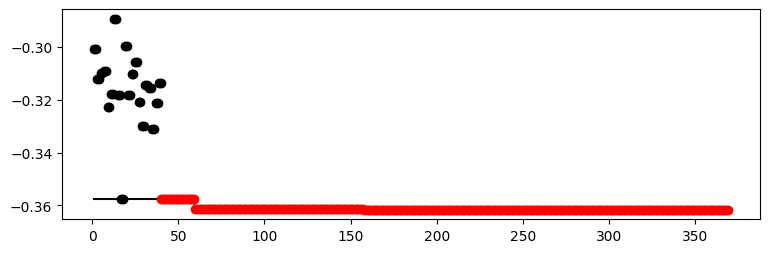

In [28]:
spot_tuner.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")



* Print the Results

In [29]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name                     | type   | default   |   lower |   upper |                 tuned | transform              |   importance | stars   |
|--------------------------|--------|-----------|---------|---------|-----------------------|------------------------|--------------|---------|
| n_estimators             | int    | 7         |     5.0 |    10.0 |                  10.0 | transform_power_2_int  |         1.64 | *       |
| criterion                | factor | gini      |     0.0 |     2.0 |                   2.0 | None                   |         0.45 | .       |
| max_depth                | int    | 10        |     1.0 |    20.0 |                   8.0 | transform_power_2_int  |         0.01 |         |
| min_samples_split        | int    | 2         |     2.0 |   100.0 |                   9.0 | None                   |       100.00 | ***     |
| min_samples_leaf         | int    | 1         |     1.0 |    25.0 |                   4.0 | None                   |        10.73 | * 

## Show variable importance

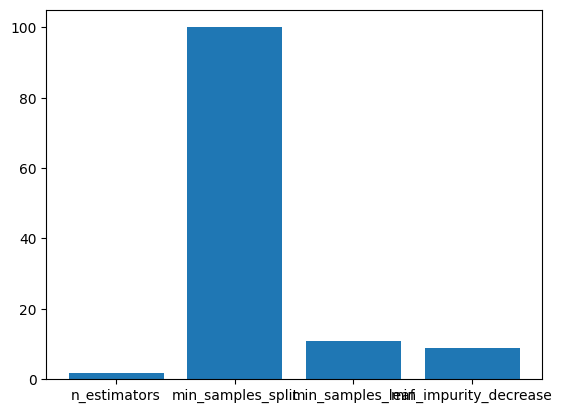

In [30]:
spot_tuner.plot_importance(threshold=1.0, filename="../Figures.d/" + experiment_name+"_importance.pdf")

## Get Default Hyperparameters

In [31]:
values_default = get_default_values(fun_control)
values_default = transform_hyper_parameter_values(fun_control=fun_control, hyper_parameter_values=values_default)
values_default

{'n_estimators': 128,
 'criterion': 'gini',
 'max_depth': 1024,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 'sqrt',
 'max_leaf_nodes': 1024,
 'min_impurity_decrease': 0.0,
 'bootstrap': 1,
 'oob_score': 0}

In [32]:
model_default = make_pipeline(fun_control["prep_model"], fun_control["core_model"](**values_default))
model_default

Pipeline(steps=[('nonetype', None),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=1, max_depth=1024,
                                        max_leaf_nodes=1024, n_estimators=128,
                                        oob_score=0))])

## Get SPOT Results

In [33]:
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
print(X)

[[1.00000000e+01 2.00000000e+00 8.00000000e+00 9.00000000e+00
  4.00000000e+00 7.74847316e-04 0.00000000e+00 1.10000000e+01
  8.95043490e-03 1.00000000e+00 1.00000000e+00]]


In [34]:
v_dict = assign_values(X, fun_control["var_name"])
return_conf_list_from_var_dict(var_dict=v_dict, fun_control=fun_control)

[{'n_estimators': 1024,
  'criterion': 'log_loss',
  'max_depth': 256,
  'min_samples_split': 9,
  'min_samples_leaf': 4,
  'min_weight_fraction_leaf': 0.0007748473157236698,
  'max_features': 'sqrt',
  'max_leaf_nodes': 2048,
  'min_impurity_decrease': 0.00895043489805583,
  'bootstrap': 1,
  'oob_score': 1}]

In [35]:
model_spot = get_one_sklearn_model_from_X(X, fun_control)
model_spot

RandomForestClassifier(bootstrap=1, criterion='log_loss', max_depth=256,
                       max_leaf_nodes=2048,
                       min_impurity_decrease=0.00895043489805583,
                       min_samples_leaf=4, min_samples_split=9,
                       min_weight_fraction_leaf=0.0007748473157236698,
                       n_estimators=1024, oob_score=1)

## Evaluate SPOT Results

* Fetch the data.

In [36]:
X_train, y_train = get_Xy_from_df(fun_control["train"], fun_control["target_column"])
X_test, y_test = get_Xy_from_df(fun_control["test"], fun_control["target_column"])
X_test.shape, y_test.shape

((177, 64), (177,))

* Fit the model with the tuned hyperparameters. This gives one result:

In [37]:
model_spot.fit(X_train, y_train)
y_pred = model_spot.predict_proba(X_test)
res = mapk_score(y_true=y_test, y_pred=y_pred, k=3)
res

0.3512241054613936

In [38]:
def repeated_eval(n, model):
    res_values = []
    for i in range(n):
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)
        res = mapk_score(y_true=y_test, y_pred=y_pred, k=3)
        res_values.append(res)
    mean_res = np.mean(res_values)
    print(f"mean_res: {mean_res}")
    std_res = np.std(res_values)
    print(f"std_res: {std_res}")
    min_res = np.min(res_values)
    print(f"min_res: {min_res}")
    max_res = np.max(res_values)
    print(f"max_res: {max_res}")
    median_res = np.median(res_values)
    print(f"median_res: {median_res}")
    return mean_res, std_res, min_res, max_res, median_res

### Handling Non-deterministic Results

* Because the model is non-determinstic, we perform $n=30$ runs and calculate the mean and standard deviation of the performance metric.

In [39]:
_ = repeated_eval(30, model_spot)

mean_res: 0.3594789704959197
std_res: 0.007531714168294961
min_res: 0.34651600753295675
max_res: 0.3757062146892655
median_res: 0.3587570621468927


### Evalution of the Default Hyperparameters


In [40]:
model_default.fit(X_train, y_train)["randomforestclassifier"]

RandomForestClassifier(bootstrap=1, max_depth=1024, max_leaf_nodes=1024,
                       n_estimators=128, oob_score=0)

* One evaluation of the default hyperparameters is performed on the hold-out test set.

In [41]:
y_pred = model_default.predict_proba(X_test)
mapk_score(y_true=y_test, y_pred=y_pred, k=3)

0.33709981167608283

Since one single evaluation is not meaningful, we perform, similar to the evaluation of the SPOT results,  $n=30$ runs of the default setting and and calculate the mean and standard deviation of the performance metric.

In [42]:
_ = repeated_eval(30, model_default)

mean_res: 0.34805398618957945
std_res: 0.013579106314650626
min_res: 0.33050847457627114
max_res: 0.3851224105461394
median_res: 0.3479284369114878


## Plot: Compare Predictions

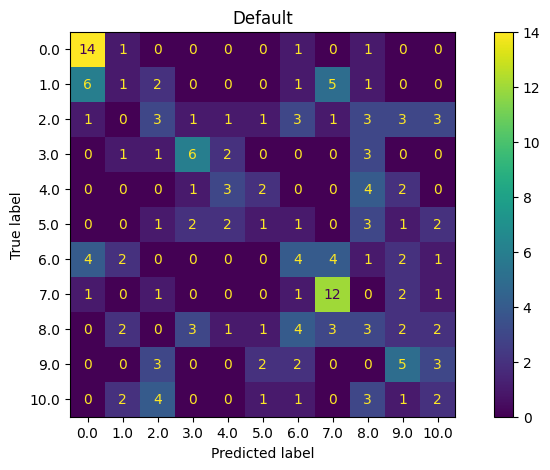

In [43]:
plot_confusion_matrix(model_default, fun_control, title = "Default")

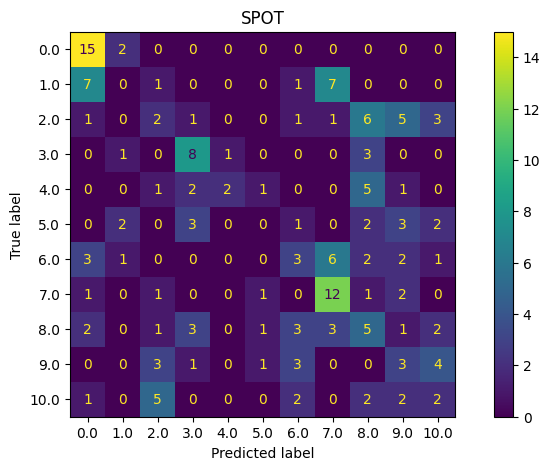

In [44]:
plot_confusion_matrix(model_spot, fun_control, title="SPOT")

In [45]:
min(spot_tuner.y), max(spot_tuner.y)

(-0.36163522012578614, -0.2893081761006289)

## Cross-validated Evaluations

In [46]:
from spotPython.sklearn.traintest import evaluate_cv
fun_control.update({
     "eval": "train_cv",
     "k_folds": 20,
})
evaluate_cv(model=model_spot, fun_control=fun_control, verbose=0)

(0.36358024691358026, None)

In [52]:
fun_control.update({
     "eval": "test_cv",
     "k_folds": 10,
})
evaluate_cv(model=model_spot, fun_control=fun_control, verbose=0)

(0.3242919389978213, None)

In [48]:
fun_control.update({
     "eval": "data_cv",
     "k_folds": 50,
})
evaluate_cv(model=model_spot, fun_control=fun_control, verbose=0)

(0.3693650793650793, None)

## Detailed Hyperparameter Contour Plots

* For productive use, you might want to select:
  * `min_z=min(spot_tuner.y)` and
  * `max_z = max(spot_tuner.y)`
* These settings are not so colorful as visualizations that use `None` for the ranges, but give better insights.

n_estimators:  1.6435963656040025
criterion:  0.4469891560633585
min_samples_split:  100.0
min_samples_leaf:  10.73054508427598
min_weight_fraction_leaf:  0.03498734506730721
min_impurity_decrease:  8.704979376963513


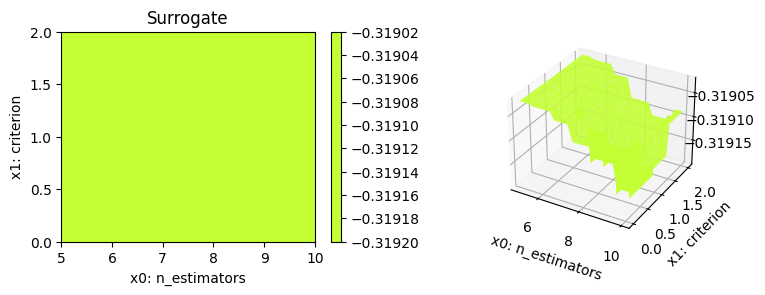

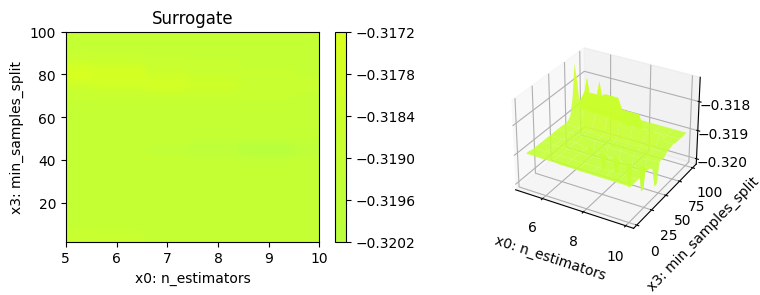

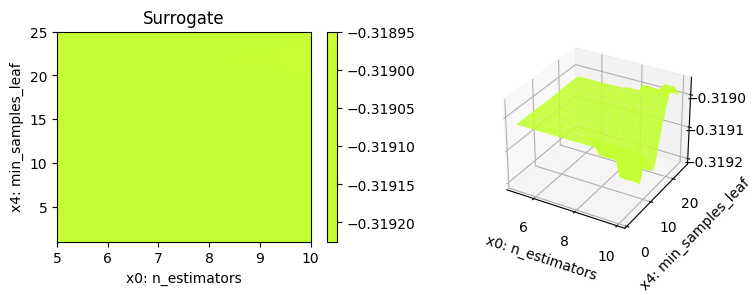

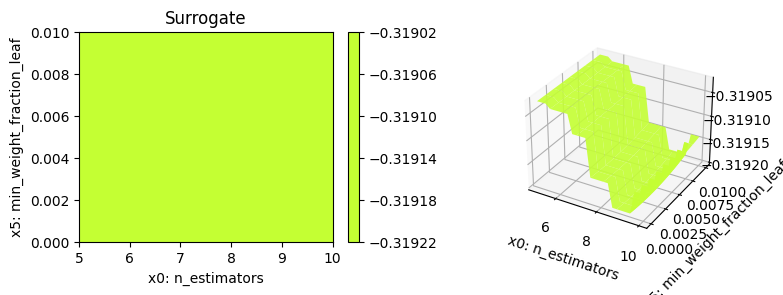

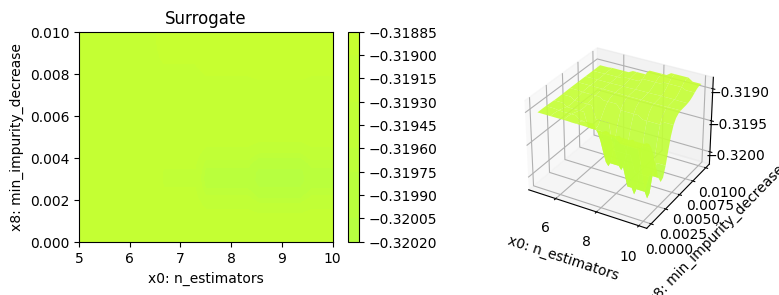

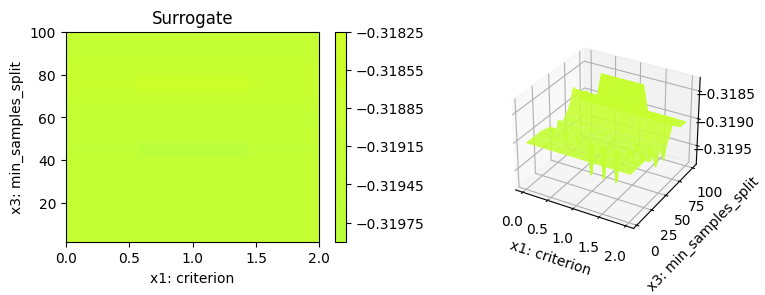

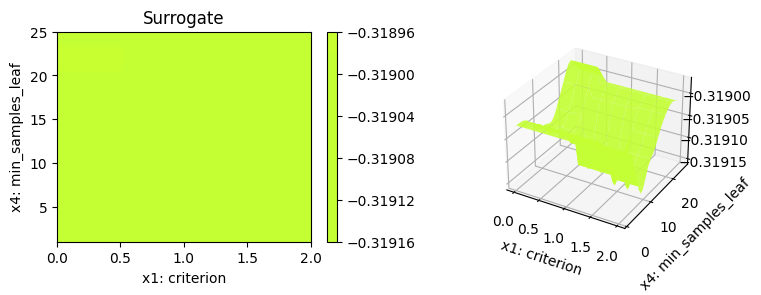

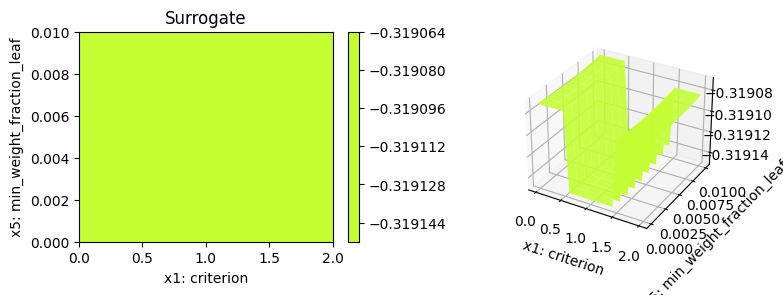

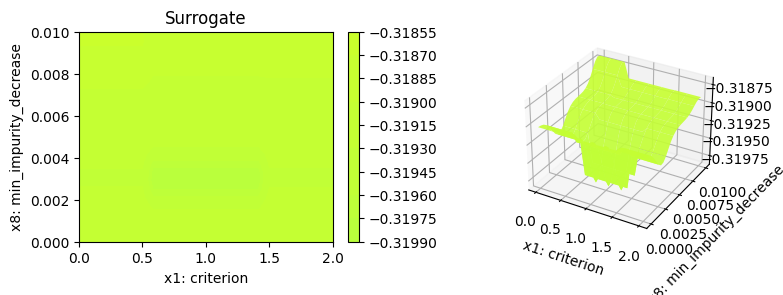

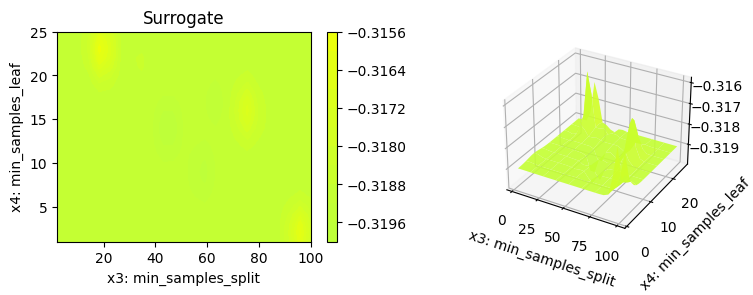

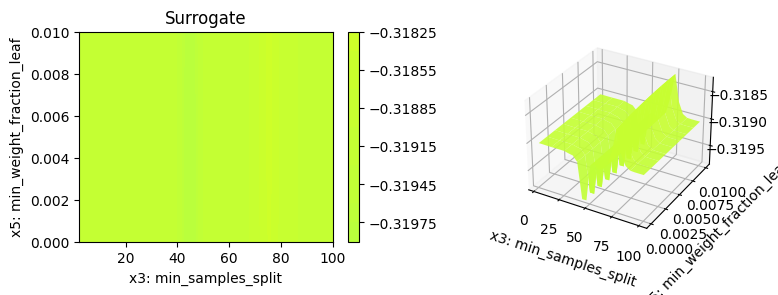

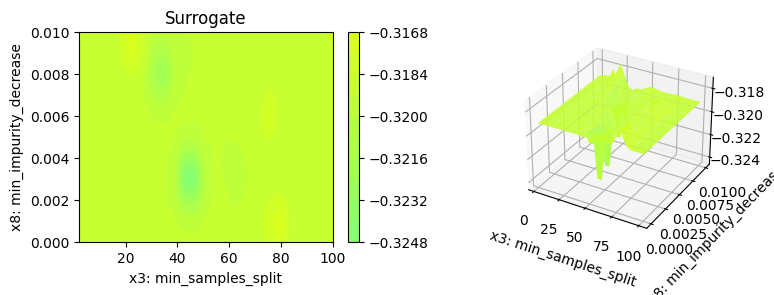

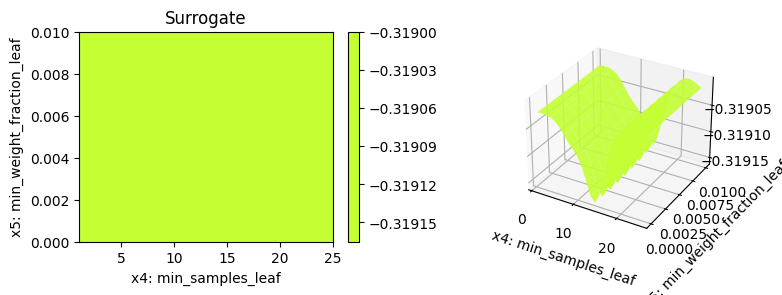

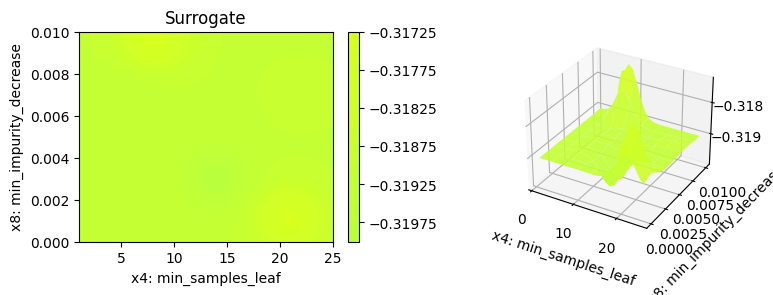

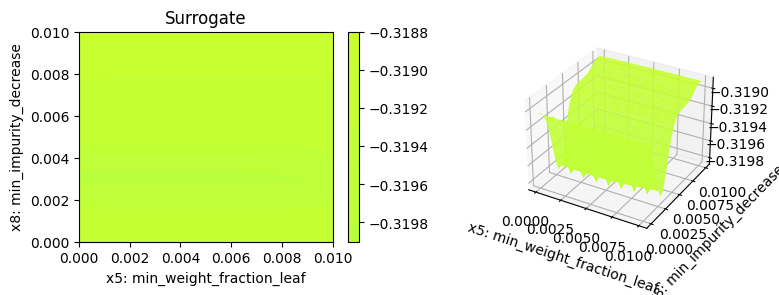

In [49]:
spot_tuner.plot_important_hyperparameter_contour(threshold=0.025)

## Parallel Coordinates Plot

In [50]:
spot_tuner.parallel_plot()

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [51]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)